In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    confusion_matrix,
    classification_report,
    make_scorer
)
import seaborn as sns
import matplotlib.pyplot as plt

# RandomForestClassifier Jellyfish


Limpiando variables de Radios ('rad')...
⚠️ Eliminando 12 columnas 'Rad':
Features restantes: 13

Datos para entrenar: 590
Distribución: {0: 472, 1: 118}

Buscando mejores hiperparámetros...

Fitting 3 folds for each of 24 candidates, totalling 72 fits

=== MEJORES HIPERPARÁMETROS ===
{'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Mejor F1-score en validación: 0.7758667256505949

=== DESEMPEÑO EN TEST ===
              precision    recall  f1-score   support

           0       0.96      0.95      0.95        94
           1       0.80      0.83      0.82        24

    accuracy                           0.92       118
   macro avg       0.88      0.89      0.88       118
weighted avg       0.93      0.92      0.92       118


F1-test (macro): 0.8840990941831278


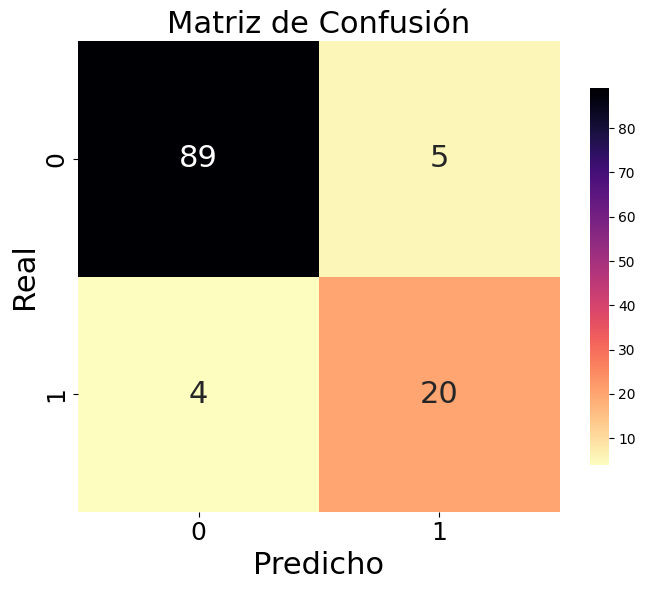

/tmp/ipykernel_1847556/3328575770.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values[:top_n], y=importances.index[:top_n], palette="viridis")


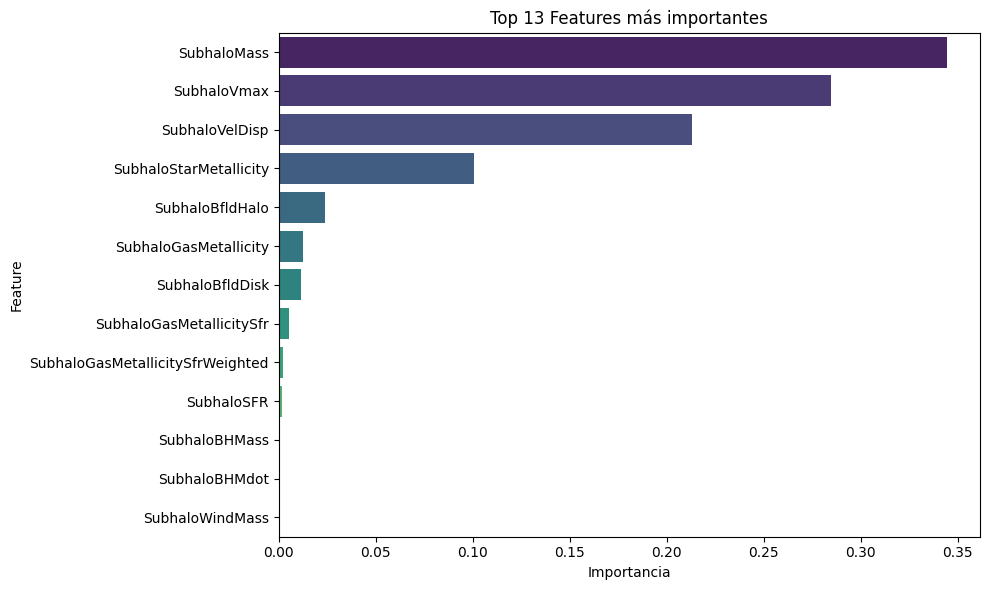


Top 10 features más importantes:
SubhaloMass                         0.344208
SubhaloVmax                         0.284858
SubhaloVelDisp                      0.212968
SubhaloStarMetallicity              0.100543
SubhaloBfldHalo                     0.023896
SubhaloGasMetallicity               0.012595
SubhaloBfldDisk                     0.011337
SubhaloGasMetallicitySfr            0.005478
SubhaloGasMetallicitySfrWeighted    0.002279
SubhaloSFR                          0.001836
dtype: float64


In [16]:
# ====================================================
# 1) DATOS Y LIMPIEZA DE "RAD"
# ====================================================
df = pd.read_pickle("tng099_clean.pkl")

print("Limpiando variables de Radios ('rad')...")
all_cols = df.columns
rad_cols = [c for c in all_cols if 'rad' in c.lower() and c != 'JellyfishFlag']

if len(rad_cols) > 0:
    print(f" Eliminando {len(rad_cols)} columnas 'Rad':")
    df = df.drop(columns=rad_cols)

print(f"Features restantes: {df.shape[1] - 1}") # -1 por el flag

# ====================================================
# 2) BALANCEO (Undersampling)
# ====================================================
df_jelly = df.copy()

df_jf = df_jelly[df_jelly["JellyfishFlag"] == 1]


df_nj = df_jelly[(df_jelly["JellyfishFlag"] == 0)].sample(
    n=len(df_jf)*4,  
    random_state=42
)

df_bal = pd.concat([df_jf, df_nj]).sample(frac=1, random_state=42)

X = df_bal.drop("JellyfishFlag", axis=1)
y = df_bal["JellyfishFlag"]

print(f"\nDatos para entrenar: {len(X)}")
print(f"Distribución: {y.value_counts().to_dict()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# ====================================================
# 3) DEFINIR LA MÉTRICA A OPTIMIZAR (F1 macro)
# ====================================================
f1_macro = make_scorer(f1_score, average="macro")

# ====================================================
# 4) GRID SEARCH: Random Forest
# ====================================================
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15, None], # Agregué 15 como punto medio
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"],
    "class_weight": ["balanced"]
}

rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

grid = GridSearchCV(
    rf_base,
    param_grid,
    scoring=f1_macro,
    cv=3,
    n_jobs=-1,
    verbose=1
)

print("\nBuscando mejores hiperparámetros...\n")
grid.fit(X_train, y_train)

# ====================================================
# 5) RESULTADOS DEL GRID SEARCH
# ====================================================
print("\n=== MEJORES HIPERPARÁMETROS ===")
print(grid.best_params_)
print("\nMejor F1-score en validación:", grid.best_score_)

# ====================================================
# 6) MODELO FINAL Y EVALUACIÓN
# ====================================================
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("\n=== DESEMPEÑO EN TEST ===")
print(classification_report(y_test, y_pred))

f1_test = f1_score(y_test, y_pred, average="macro")
print("\nF1-test (macro):", f1_test)

# ====================================================
# 7) MATRIZ DE CONFUSIÓN
# ====================================================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,6))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="magma_r",
    annot_kws={"size": 22},      
    cbar_kws={"shrink": 0.8}
)

plt.xlabel("Predicho", fontsize=22)
plt.ylabel("Real", fontsize=22)
plt.title("Matriz de Confusión", fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.tight_layout()
plt.savefig("img/matriz_confusion_jf", dpi=300)
plt.show()

# ====================================================
# 8) IMPORTANCIA DE FEATURES
# ====================================================
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

top_n = min(20, len(importances))

plt.figure(figsize=(10,6))
sns.barplot(x=importances.values[:top_n], y=importances.index[:top_n], palette="viridis")
plt.title(f"Top {top_n} Features más importantes")
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print("\nTop 10 features más importantes:")
print(importances.head(10))

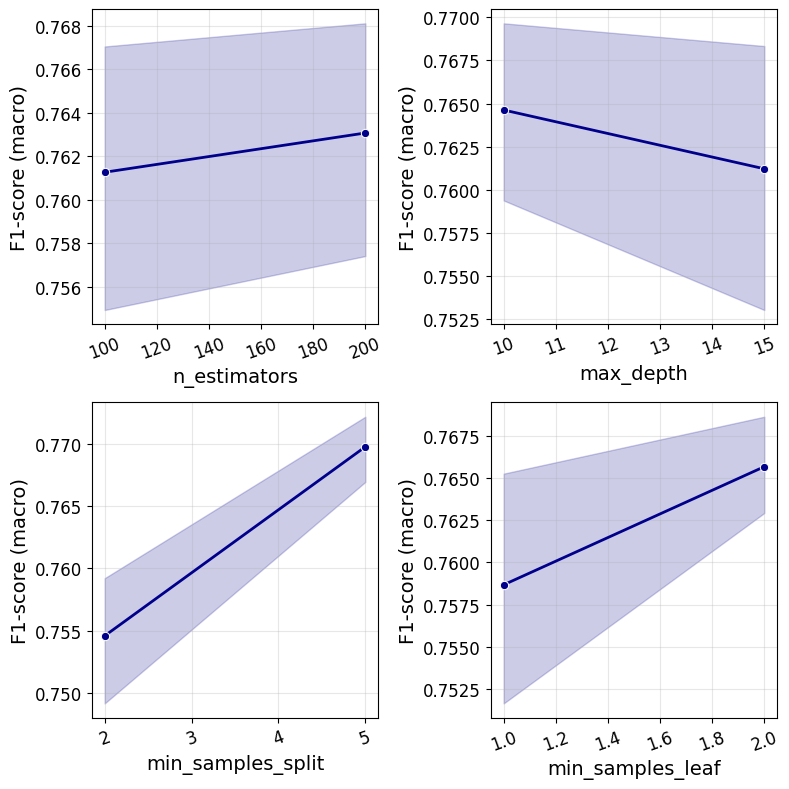

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


res = pd.DataFrame(grid.cv_results_)
res["f1"] = res["mean_test_score"] 

# Parámetros a graficar en un solo panel
params = [
    "param_n_estimators",
    "param_max_depth",
    "param_min_samples_split",
    "param_min_samples_leaf"
]

titles = [
    "n_estimators",
    "max_depth",
    "min_samples_split",
    "min_samples_leaf"
]

plt.figure(figsize=(8, 8))  

for i, (param, title) in enumerate(zip(params, titles), 1):

    plt.subplot(2, 2, i)

    vals = res[param].apply(lambda x: np.nan if x is None else x)

    sns.lineplot(
        x=vals,
        y=res["f1"],
        marker="o",
        lw=2,
        ms=6,
        color="darkblue"
    )

    plt.xlabel(title, fontsize=14)
    plt.ylabel("F1-score (macro)", fontsize=14)
    plt.xticks(fontsize=12, rotation=20)
    plt.yticks(fontsize=12)
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("img/jf_hyperparam_grid_all.png", dpi=300)
plt.show()
